# Practice notebook for confidence intervals using NHANES data

This notebook will give you the opportunity to practice working with confidence intervals using the NHANES data.

You can enter your code into the cells that say "enter your code here", and you can type responses to the questions into the cells that say "Type Markdown and Latex".

Note that most of the code that you will need to write below is very similar to code that appears in the case study notebook.  You will need to edit code from that notebook in small ways to adapt it to the prompts below.

To get started, we will use the same module imports and read the data in the same way as we did in the case study:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm

da = pd.read_csv("nhanes_2015_2016.csv")

In [2]:
da.head()

,SEQN,ALQ101,ALQ110,ALQ130,SMQ020,RIAGENDR,RIDAGEYR,RIDRETH1,DMDCITZN,DMDEDUC2,...,BPXSY2,BPXDI2,BMXWT,BMXHT,BMXBMI,BMXLEG,BMXARML,BMXARMC,BMXWAIST,HIQ210
0,83732,1.0,NaN,1.0,1,1,62,3,1.0,5.0,...,124.0,64.0,94.8,184.5,27.8,43.3,43.6,35.9,101.1,2.0
1,83733,1.0,NaN,6.0,1,1,53,3,2.0,3.0,...,140.0,88.0,90.4,171.4,30.8,38.0,40.0,33.2,107.9,NaN
2,83734,1.0,NaN,NaN,1,1,78,3,1.0,3.0,...,132.0,44.0,83.4,170.1,28.8,35.6,37.0,31.0,116.5,2.0
3,83735,2.0,1.0,1.0,2,2,56,3,1.0,5.0,...,134.0,68.0,109.8,160.9,42.4,38.5,37.7,38.3,110.1,2.0
4,83736,2.0,1.0,1.0,2,2,42,4,1.0,4.0,...,114.0,54.0,55.2,164.9,20.3,37.4,36.0,27.2,80.4,2.0


## Question 1

Restrict the sample to women between 35 and 50, then use the marital status variable [DMDMARTL](https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/DEMO_I.htm#DMDMARTL) to partition this sample into two groups - women who are currently married, and women who are not currently married.  Within each of these groups, calculate the proportion of women who have completed college.  Calculate 95% confidence intervals for each of these proportions.

In [3]:
da["Married"] = da.DMDMARTL.replace({1: "yes", 
                                         2: "no", 
                                         3: "no", 
                                         4: "no", 
                                         5: "no",
                                         6: "no",
                                         77: np.nan,
                                         99: np.nan}).dropna()

da["Complete_coll"] = da.DMDEDUC2.replace({5: "complete_college"}).dropna()
da["Gender"] = da.RIAGENDR.replace({1:"Male", 2:"Female"}).dropna()
da["agegrp"] = pd.cut(da.RIDAGEYR, [35, 50])

In [4]:
pr = da.loc[da["Gender"]=="Female"].groupby(["agegrp", "Married"]).agg({
    "Complete_coll": [lambda x: np.mean(x=="complete_college"), np.size]
})
pr.columns = ["mean", "total_n"]
pr

mean  total_n
agegrp   Married                   
(35, 50] no       0.208723      321
         yes      0.367542      419

In [5]:
no_marr_p = pr["mean"][0]
no_marr_n = pr.total_n[0]
yes_marr_p = pr["mean"][1]
yes_marr_n = pr.total_n[1]

print("No Married Women with College:", 
      sm.stats.proportion_confint(no_marr_n * no_marr_p, no_marr_n))
print("Married Women with College:", 
      sm.stats.proportion_confint(yes_marr_n * yes_marr_p, yes_marr_n))

No Married Women with College: (0.16426526549807702, 0.2531802173679666)
Married Women with College: (0.3213770303614961, 0.41370650185807434)


__Q1a.__ Identify which of the two confidence intervals is wider 

Married Women with college have a wider confidence interval. But this is almost equal as no married women

__Q1b.__ Write 1-2 sentences summarizing these findings for an audience that does not know what a confidence interval is (the goal here is to report the substance of what you learned about how marital status and educational attainment are related, not to teach a person what a confidence interval is).

With a 95% of confidence, we estimate that married women between 35 and 50 years old with college complete are between 31.48% and 42.03%.

## Question 2

Construct a 95% confidence interval for the proportion of smokers who are female. Construct a 95% confidence interval for the proportion of smokers who are male. Construct a 95% confidence interval for the **difference** between those two gender proportions.

In [6]:
sp = da["Smokers"] = da.SMQ020.replace({1:"Yes", 2:"No"})
sp = da.groupby(da.Gender).agg({"Smokers": [lambda x: np.mean(x=="Yes"), np.size]})
sp.columns = ["mean", "total_n"]
sp

,mean,total_n
Gender,,
Female,0.304435,2976
Male,0.512142,2759


In [7]:
sp["mean"]["Female"]

0.30443548387096775

In [8]:
sp_fp = sp["mean"]["Female"]
sp_fn = sp.total_n.Female
sp_mp = sp["mean"]["Male"]
sp_mn = sp.total_n.Male
ci_pr_f = sm.stats.proportion_confint(sp_fn * sp_fp, sp_fn)
ci_pr_m = sm.stats.proportion_confint(sp_mn * sp_mp, sp_mn)

In [9]:
print("Confidence Interval Smoking Women:", ci_pr_f)
print("Confidence Interval Smoking Men:", ci_pr_m)

Confidence Interval Smoking Women: (0.2879026244757051, 0.3209683432662304)
Confidence Interval Smoking Men: (0.49349056386167417, 0.5307935970661982)


In [10]:
#  np.sqrt(se.Female**2 + se.Male**2)
se_f = np.sqrt(sp_fp * (1 - sp_fp) / sp_fn)
se_m = np.sqrt(sp_mp * (1 - sp_mp) / sp_mn)
se_diff = np.sqrt(se_f**2 + se_m**2)
print("Female Standard Error:", se_f)
print("Male Standard Error:", se_m)
print("Difference Standard Errors:", se_diff)


Female Standard Error: 0.008435287344906213
Male Standard Error: 0.009516254762527675
Difference Standard Errors: 0.012716649609722899


In [11]:
diff_p = sp_fp - sp_mp
lcb = diff_p - 1.96 * se_diff
ucb = diff_p + 1.96 * se_diff
print("Difference of Smoker Gender Proportion:", lcb,ucb)

Difference of Smoker Gender Proportion: -0.2326312298280253 -0.18278196335791153


## Question 3

Construct a 95% interval for height ([BMXHT](https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/BMX_I.htm#BMXHT)) in centimeters.  Then convert height from centimeters to inches by dividing by 2.54, and construct a 95% confidence interval for height in inches.  Finally, convert the endpoints (the lower and upper confidence limits) of the confidence interval from inches to back to centimeters   

In [12]:
da["height"] = da.BMXHT > 160

In [13]:
cm_height = da.height.dropna()
cm_height = [da.height.mean(), da.BMXHT.size]
cm_height_p = cm_height[0]
cm_height_n = cm_height[1]
cm_height_p, cm_height_n

(0.6967741935483871, 5735)

In [14]:
ci_cm_height = sm.stats.proportion_confint(cm_height_n * cm_height_p, cm_height_n)
ci_cm_height

(0.6848779324238082, 0.708670454672966)

In [15]:
da["height_inch"] = (da.BMXHT / 2.54) > 62

In [16]:

inch_height = da.height_inch.dropna()
inch_height = [da.height_inch.mean(), da.BMXHT.size]
inch_height_p = inch_height[0]
inch_height_n = inch_height[1]
inch_height_p, inch_height_n

(0.7797733217088055, 5735)

In [17]:
ci_inch_height = sm.stats.proportion_confint(inch_height_n * inch_height_p, inch_height_n)
ci_inch_height

(0.7690482419546796, 0.7904984014629315)

In [18]:
ci_inch_height[0] * 2.64, ci_inch_height[1] * 2.64

(2.0302873587603543, 2.086915779862139)

## Question 4

Partition the sample based on 10-year age bands, i.e. the resulting groups will consist of people with ages from 18-28, 29-38, etc. Construct 95% confidence intervals for the difference between the mean BMI for females and for males within each age band.

In [19]:
da["agegrpx"] = pd.cut(da.RIDAGEYR, [18, 28, 38, 48, 58, 68, 78]).dropna()

In [20]:
bmi = da.groupby(["agegrpx", "Gender"]).agg({"BMXBMI": [np.mean, np.std, np.size]}).unstack()
bmi

BMXBMI                                             
               mean                  std             size       
Gender       Female       Male    Female      Male Female   Male
agegrpx                                                         
(18, 28]  28.019433  27.058186  8.048854  6.679515  498.0  458.0
(28, 38]  29.943443  29.697180  7.959097  6.726690  494.0  467.0
(38, 48]  31.003733  29.514646  8.044642  6.104950  514.0  398.0
(48, 58]  30.787361  29.385132  7.647590  6.151534  454.0  419.0
(58, 68]  31.054664  29.232462  7.779502  5.959024  466.0  470.0
(68, 78]  30.537818  28.720270  6.780588  5.336652  279.0  307.0

In [21]:
bmi["BMXBMI", "sem", "Female"] = bmi["BMXBMI", "std", "Female"] / np.sqrt(bmi["BMXBMI", "size", "Female"]) 
bmi["BMXBMI", "sem", "Male"] = bmi["BMXBMI", "std", "Male"] / np.sqrt(bmi["BMXBMI", "size", "Male"]) 
print(bmi["BMXBMI", "sem", "Female"])
print(bmi["BMXBMI", "sem", "Male"])

agegrpx
(18, 28]    0.360678
(28, 38]    0.358097
(38, 48]    0.354834
(48, 58]    0.358919
(58, 68]    0.360378
(68, 78]    0.405943
Name: (BMXBMI, sem, Female), dtype: float64
agegrpx
(18, 28]    0.312113
(28, 38]    0.311274
(38, 48]    0.306014
(48, 58]    0.300522
(58, 68]    0.274869
(68, 78]    0.304579
Name: (BMXBMI, sem, Male), dtype: float64


In [22]:
bmi["BMXBMI", "mean_diff", ""] = bmi["BMXBMI", "mean", "Female"] - bmi["BMXBMI", "mean", "Male"]
bmi["BMXBMI", "sem_diff", ""] = np.sqrt(bmi["BMXBMI", "sem", "Female"]**2 + bmi["BMXBMI", "sem", "Male"]**2) 
bmi["BMXBMI", "lcb_diff", ""] = bmi["BMXBMI", "mean_diff", ""] - 1.96 * bmi["BMXBMI", "sem_diff", ""] 
bmi["BMXBMI", "ucb_diff", ""] = bmi["BMXBMI", "mean_diff", ""] + 1.96 * bmi["BMXBMI", "sem_diff", ""]
print(bmi["BMXBMI", "mean_diff", ""])
print(bmi["BMXBMI", "sem_diff", ""])
print(bmi["BMXBMI", "lcb_diff", ""])
print(bmi["BMXBMI", "ucb_diff", ""])

agegrpx
(18, 28]    0.961247
(28, 38]    0.246263
(38, 48]    1.489086
(48, 58]    1.402230
(58, 68]    1.822202
(68, 78]    1.817548
Name: (BMXBMI, mean_diff, ), dtype: float64
agegrpx
(18, 28]    0.476973
(28, 38]    0.474473
(38, 48]    0.468563
(48, 58]    0.468120
(58, 68]    0.453239
(68, 78]    0.507502
Name: (BMXBMI, sem_diff, ), dtype: float64
agegrpx
(18, 28]    0.026381
(28, 38]   -0.683705
(38, 48]    0.570703
(48, 58]    0.484714
(58, 68]    0.933853
(68, 78]    0.822844
Name: (BMXBMI, lcb_diff, ), dtype: float64
agegrpx
(18, 28]    1.896114
(28, 38]    1.176230
(38, 48]    2.407470
(48, 58]    2.319745
(58, 68]    2.710551
(68, 78]    2.812252
Name: (BMXBMI, ucb_diff, ), dtype: float64


Text(0,0.5,'Female - male BMI difference')

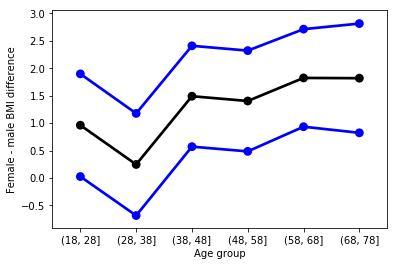

In [23]:
x = np.arange(bmi.shape[0])
pp = sns.pointplot(x, bmi["BMXBMI", "mean_diff", ""], color='black')
sns.pointplot(x, bmi["BMXBMI", "lcb_diff", ""], color='blue')
sns.pointplot(x, bmi["BMXBMI", "ucb_diff", ""], color='blue')
pp.set_xticklabels(bmi.index)
pp.set_xlabel("Age group")
pp.set_ylabel("Female - male BMI difference")